<a href="https://colab.research.google.com/github/kanikaghiloria/Image_Classification_Denoising_SementicSegmentation-ComputerVision/blob/master/ComputerVision_Image_Classification_Denoising_SementicSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import argparse
import re
import os, glob, datetime, time
import numpy as np
import torch
# import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import cv2
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave
from matplotlib import pyplot

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import numpy as np
import torchvision.transforms as T
import cv2

In [0]:
# DataGenerator.py


import numpy as np
from torch.utils.data import Dataset
import torch

patch_size, stride = 40, 10
aug_times = 1
scales = [1, 0.9, 0.8, 0.7]
batch_size = 128


class DenoisingDataset(Dataset):
    """Dataset wrapping tensors.
    Arguments:
        xs (Tensor): clean image patches
        sigma: noise level, e.g., 25
    """
    def __init__(self, xs, sigma):
        super(DenoisingDataset, self).__init__()
        self.xs = xs
        self.sigma = sigma

    def __getitem__(self, index):
        batch_x = self.xs[index]
        noise = torch.randn(batch_x.size()).mul_(self.sigma/255.0)
        batch_y = batch_x + noise
        return batch_y, batch_x

    def __len__(self):
        return self.xs.size(0)


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


def data_aug(img, mode=0):
    # data augmentation
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))


def gen_patches(file_name):
    # get multiscale patches from a single image
    img = cv2.imread(file_name, 0)  # gray scale
    h, w = img.shape
    patches = []
    for s in scales:
        h_scaled, w_scaled = int(h*s), int(w*s)
        img_scaled = cv2.resize(img, (w_scaled, h_scaled), interpolation=cv2.INTER_CUBIC)
        # extract patches
        for i in range(0, h_scaled-patch_size+1, stride):
            for j in range(0, w_scaled-patch_size+1, stride):
                x = img_scaled[i:i+patch_size, j:j+patch_size]
                for k in range(0, aug_times):
                    x_aug = data_aug(x, mode=np.random.randint(0, 8))
                    patches.append(x_aug)
    return patches


# def datagenerator(data_dir='data/Train400', verbose=False):
def datagenerator(data_dir='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/data/Train400', verbose=False):
  # generate clean patches from a dataset
  file_list = glob.glob(data_dir+'/*.jpg')  # get name list of all .jpg files
  # initrialize
  data = []
  # generate patches
  for i in range(len(file_list)):
    patches = gen_patches(file_list[i])
    for patch in patches:    
      data.append(patch)
    if verbose:
      print(str(i+1) + '/' + str(len(file_list)) + ' is done')
  data = np.array(data, dtype='uint8')
  data = np.expand_dims(data, axis=3)
  discard_n = len(data)-len(data)//batch_size*batch_size  # because of batch namalization
  data = np.delete(data, range(discard_n), axis=0)
  print('training data finished')
  return data
# if __name__ == '__main__': 

#     data = datagenerator(data_dir='data/Train400')

#Functions

In [0]:
# For mnist.py

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
	
def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.numpy()
    return data.cpu().data.numpy(), target.cpu().data.numpy(), pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

In [0]:
# For main_test.py

def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))

def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

In [0]:
# For main_train.py

class sum_squared_error(_Loss):
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)

def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).pth.*", file_)
            epochs_exist.append(int(result[0]))
        initial_epoch = max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch

#Question 1 - MNIST classification

#Question 1-a:
Best results are observed for the following values for parameters:
```
Learning Rate: 0.01
Weight decay:0.005
Accuracy: 98%
```
1-a-i) Learning rate – explain what happens when you use too large or too small value and explain why it is happening.
```
If learning rate is too large, accuracy is coming out to be very less (for example, 10% for lr=1.0). 
If learning rate is too large, gradient descent may never converge or diverge at the right point. This will result in a very low accuracy.

If the learning rate is too small, it will take a long time for the model to train. This is because it will take a long time for gradient descent
 to converge. Not only this, it is also resulting in over fitting 
of the model.
Decreasing the learning rate from 1.0 led to better results. With lr=0.01 I observer the accuracy of 98%. But decreasing the learning rate 
further led to poor results.
```
1-a-ii) Weight decay – explain what happens when you use too large or too small regularization and explain why it is happening.
```
Having large weight decay, such as 10, leads to the poor accuracy of. The value more closer to zero, such as 0.005 is giving the accuracy of 98%.
Any value lower then that is not having any further impact on accuracy.
This is because very high value of weight decay will result in model not fitting properly.
```

In [0]:
# Training hyperparameters
epochs = 1
batch_size = 64
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.005
log_interval = 20

In [0]:
use_cuda = torch.cuda.is_available()

In [0]:
 # data transformation
 train_data = datasets.MNIST('../data', train=True, download=True,
                             transform=transforms.Compose([
                                                           transforms.ToTensor(),
                                                           transforms.Normalize((0.1307,), (0.3081,))
                                                           ]))
test_data = datasets.MNIST('../data', train=False,
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.1307,), (0.3081,))
                                                         ]))

# data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, 
                               kernel_size=5, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, 
                               kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=800, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def main():
    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

	# extract and plot random samples of data
    #examples = enumerate(test_loader)
    #batch_idx, (data, target) = next(examples)
    #plot_data(data, target, 'Ground truth')
	
    # model creation
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    # plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    # plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    # plot_data(data, pred, 'Predicted')

if __name__ == '__main__':
    main()


Test set: Average loss: 4.9903, Accuracy: 967/10000 (10%)


Test set: Average loss: 0.0580, Accuracy: 9821/10000 (98%)



#Question 1-b
Modifying the class as per the model

In [0]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def main():
    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")	
    # model creation
    model = CNN2().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    # plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    # plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    # plot_data(data, pred, 'Predicted')

if __name__ == '__main__':
    main()


Test set: Average loss: 3.1437, Accuracy: 1095/10000 (11%)


Test set: Average loss: 0.0476, Accuracy: 9840/10000 (98%)



#Question 1-c: Change dataset to fashion MNIST, estimate the dataset mean and standard deviation and use it to normalize the data in the data loader.

In [0]:
t = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()]))

0it [00:00, ?it/s]

26427392it [00:00, 81220244.13it/s]                             


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


32768it [00:00, 677964.28it/s]
4423680it [00:00, 33601221.90it/s]                           

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



8192it [00:00, 240126.76it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


In [0]:
mn =(t.train_data.float().mean())/255
sd = (t.train_data.float().std())/255

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [0]:
 # data transformation
 train_data = datasets.FashionMNIST('../data', train=True, download=True,
                             transform=transforms.Compose([
                                                           transforms.ToTensor(),
                                                           transforms.Normalize((mn,), (sd,))
                                                           ]))
test_data = datasets.FashionMNIST('../data', train=False,
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((mn,), (sd,))
                                                         ]))

# data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

In [0]:
def main():
    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # model creation
    model = CNN2().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    # plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    # plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    # plot_data(data, pred, 'Predicted')

if __name__ == '__main__':
    main()


Test set: Average loss: 3.1309, Accuracy: 647/10000 (6%)


Test set: Average loss: 0.3346, Accuracy: 8781/10000 (88%)



#Question 1-d: Design CNN3 with additional regularization of your choosing. Explain benefits of such regularization and report its accurracy on fashion MNIST and its relative improvement over CNN2.




L2 regularisation is added to CNN3 by adding dropout regularisation. 
When compared to CNN2, not much difference is observed in the accuracy.

In dropout regularization, neurons are selected randomly and ignored during the training of the network. The network becomes less sensitive to the specific weights of the neurons and therefore results in the network that is capable of better generalization. Hence the data is not overfitted.
```
Accuracy on FashionMNIST dataset: 88% 
```


In [0]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        # TODO  
        # super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=5, stride=1, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout=nn.Dropout(0.05)
        self.fc1 = nn.Linear(in_features=3136, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='linear')      

    def forward(self, x):
        # TODO
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 3136)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def main():
    # use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # model creation
    model = CNN3().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
        test(model, device, test_loader, losses=test_losses, errors=test_errors)
		
    # plotting training history
    # plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')
    # plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')
	
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    # plot_data(data, pred, 'Predicted')

if __name__ == '__main__':
    main()


Test set: Average loss: 2.6112, Accuracy: 1209/10000 (12%)


Test set: Average loss: 0.3224, Accuracy: 8809/10000 (88%)



#Question 1-e:
GHILORIK@TCD.IE_out

#Question 1-f
GHILORIK@TCD.IE_params

#Question 2: Image Denoising

#Question 2-a
#Briefly explain how the authors have decided on the particular network depth. 
Effective field size of Denoising neural networks correlates with the effective patch size, and high noise level requires larger effective patch size to capture more information. Therefore the noise level was fixed to sigma = 25 and effective patch size of several leading denoising methods (BM3D, WNNM, EPLL, MLP, CSF and TNRD) were analyzed.

Hence, depth of 17 was set for Gaussian denoising with a certain noise level depth of 20 was adopted for other general image denoising tasks.
#Which tasks is the DnCNN-3 designed to solve?
DnCNN3 is designed to solve following three general image denoising tasks:
1. Blind Gaussian Denoising
2. SISR (Single Image Super Resolution)
3. JPEG Deblocking

#Question 2-b:

When sigma=25:
```
Average PSNR: 29.26dB
Average SSIM: 0.9022
```
When sigma=42 (from GHILORIK@TCD.IE_sigma.csv):
```
Average PSNR: 19.41dB
Average SSIM: 0.4567
```

#Question 2-c:

Results after fine tuning the pre trained model:
```
Average PSNR:26.23dB
Average SSIM:0.8225
```

#Question 2-d:
GHILORIK@TCD.IE_006_pretrained

GHILORIK@TCD.IE_006_clean

GHILORIK@TCD.IE_psnr




#Question 2-e:
Standard Deviation of the noise in image:
```
0.144615
```



main_train.py

In [0]:
# Params
parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--batch_size', default=128, type=int, help='batch size')
# parser.add_argument('--train_data', default='data/Train400', type=str, help='path of train data')
# parser.add_argument('--sigma', default=25, type=int, help='noise level')
# parser.add_argument('--epochs', default=20, type=int, help='number of train epochs')
# parser.add_argument('--lr', default=1e-3, type=float, help='initial learning rate for Adam')

parser.add_argument('--train_data', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/data/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=42, type=int, help='noise level')
parser.add_argument('--epochs', default=1, type=int, help='number of train epochs')
parser.add_argument('--lr', default=0.0001, type=float, help='initial learning rate for Adam')

args = parser.parse_args(args=[])

batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epochs = args.epochs
sigma = args.sigma

# save_dir = 'models'
save_dir = '/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/models_new'

In [0]:
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

In [0]:
if __name__ == '__main__':
    # model selection
    print('===> Building model')
    model = DnCNN()
    
    initial_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
    if initial_epoch > 0 or os.path.isfile(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch)):
        print('resuming by loading epoch %03d' % initial_epoch)
        model = torch.load(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch))
    model.train()
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = MultiStepLR(optimizer, milestones=[15], gamma=0.1)  # learning rates
    for epoch in range(initial_epoch, n_epochs):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        # xs = dg.datagenerator(data_dir=args.train_data)
        xs = datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=0, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
            optimizer.zero_grad()
            if cuda:
                batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
            else:
                batch_x, batch_y = batch_yx[1], batch_yx[0]
            loss = criterion(model(batch_y), batch_x)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            if n_count % 100 == 0:
                print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

===> Building model


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


training data finished
   1    0 / 11390 loss = 330.8376
   1  100 / 11390 loss = 18.6092
   1  200 / 11390 loss = 11.7206
   1  300 / 11390 loss = 9.8349
   1  400 / 11390 loss = 8.4002
   1  500 / 11390 loss = 7.7117
   1  600 / 11390 loss = 6.6345
   1  700 / 11390 loss = 6.1816
   1  800 / 11390 loss = 5.7192
   1  900 / 11390 loss = 5.4200
   1 1000 / 11390 loss = 5.0082
   1 1100 / 11390 loss = 4.7278
   1 1200 / 11390 loss = 4.5280
   1 1300 / 11390 loss = 4.2952
   1 1400 / 11390 loss = 4.4146
   1 1500 / 11390 loss = 3.9818
   1 1600 / 11390 loss = 4.0196
   1 1700 / 11390 loss = 3.8900
   1 1800 / 11390 loss = 3.4526
   1 1900 / 11390 loss = 3.8362
   1 2000 / 11390 loss = 3.5721
   1 2100 / 11390 loss = 3.1655
   1 2200 / 11390 loss = 3.1255
   1 2300 / 11390 loss = 3.3244
   1 2400 / 11390 loss = 3.3888
   1 2500 / 11390 loss = 3.5046
   1 2600 / 11390 loss = 3.3403
   1 2700 / 11390 loss = 3.1421
   1 2800 / 11390 loss = 3.2963
   1 2900 / 11390 loss = 3.2925
   1 3000 / 1

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-p

main_test.py

In [0]:
def parse_args():
  parser = argparse.ArgumentParser()
  # parser.add_argument('--set_dir', default='data/Test', type=str, help='directory of test dataset')
  # parser.add_argument('--set_dir', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/data/Test', type=str, help='directory of test dataset')
  parser.add_argument('--set_dir', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/TestImage', type=str, help='directory of test dataset')
  parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
  # parser.add_argument('--sigma', default=25, type=int, help='noise level')
  parser.add_argument('--sigma', default=42, type=int, help='noise level')
  # parser.add_argument('--model_path', default='models/model_000.pth', type=str, help='the model name')
  # parser.add_argument('--model_path', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/models/model_000.pth', type=str, help='the model name')
  parser.add_argument('--model_path', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/models_new/model_001.pth', type=str, help='the model name')
  parser.add_argument('--result_dir', default='/content/drive/My Drive/Colab Notebooks/ComputerVision/DnCNN/results', type=str, help='directory of test dataset')
  parser.add_argument('--save_result', action='store_true', help='save the denoised image')
  # print (parser.parse_args())
  return parser.parse_args(args=[])

In [0]:
class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

2019-11-24 04:34:12: load trained model
     Set68 : GHILORIK@TCD.IE_006.png : 0.0293 second
Denoising the Image using fine tune model:


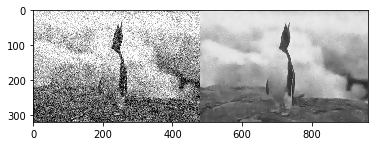

Residual Image:


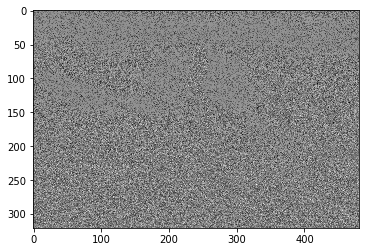

2019-11-24 04:34:13: Datset: Set68      
  PSNR = 16.79dB, SSIM = 0.2424


In [0]:
if __name__ == '__main__':
  # print ("flag 1")
  args = parse_args()
  # print ("flag 2")
  model = torch.load(args.model_path)
  log('load trained model')
  
  model.eval()  # evaluation mode
  # print ("flag 3")
  if torch.cuda.is_available():
    model = model.cuda()

  if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)

  for set_cur in args.set_names:
    if not os.path.exists(os.path.join(args.result_dir, set_cur)):
      os.mkdir(os.path.join(args.result_dir, set_cur))
    psnrs = []
    ssims = []

    for im in os.listdir(os.path.join(args.set_dir, set_cur)):
      if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):
        x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
        np.random.seed(seed=0)  # for reproducibility
        # y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
        y = x
        y = y.astype(np.float32)
        y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

        torch.cuda.synchronize()
        start_time = time.time()
        y_ = y_.cuda()
        x_ = model(y_)  # inference
        x_ = x_.view(y.shape[0], y.shape[1])
        x_ = x_.cpu()
        x_ = x_.detach().numpy().astype(np.float32)
        torch.cuda.synchronize()
        elapsed_time = time.time() - start_time
        print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

        psnr_x_ = compare_psnr(x, x_)
        ssim_x_ = compare_ssim(x, x_)

        residualImg = np.subtract(x, x_)
        y_temp = x_ + residualImg
        args.save_result='True'
        if args.save_result:
          name, ext = os.path.splitext(im)
          # show(temp)
          # show(temp1)
          # show(y_temp)
          # show(np.hstack((y, y_temp)))  # show the image
          print ("Denoising the Image using fine tune model:")
          show(np.hstack((y, x_)))  # show the image
          print ("Residual Image:")
          show(residualImg)
          # save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
          # save_result(residualImg, path=os.path.join(args.result_dir, set_cur, name+'_noise'+ext))  # save the denoised image
          # plt.imsave(os.path.join(args.result_dir, set_cur, name+'_noise'+ext), np.uint8(np.clip(residualImg*255.0, 0, 255)), cmap='gray', vmin=0, vmax=127)
        psnrs.append(psnr_x_)
        ssims.append(ssim_x_)
    psnr_avg = np.mean(psnrs)
    ssim_avg = np.mean(ssims)
    psnrs.append(psnr_avg)
    ssims.append(ssim_avg)
    if args.save_result:
      # save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
      save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, '/content/drive/My Drive/Colab Notebooks/ComputerVision/results.txt'))
    log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))

In [0]:
mean, std = cv2.meanStdDev(residualImg)

In [0]:
print (std)

[[0.144615]]


#Question 3: Semantic segmentation

#Question 3-a: Briefly Explain:
3-a-i) How FCN upsamples predictions to match the original image size?
```
FCN uses backward convolution (also known as deconvolution) with an outward stride of f (f-32 in the paper).
```
3-a-ii) How had the authors improved the coarse predictions produced by the deepest layer?
```
Authors have used Skip Architecture for this task. They added skips between FCN's layers to fuse coarse information. It refines the semantics 
and spatial precision of the output.
```

#Question 3-b
GHILORIK@TCD.IE_predicted


#Question 3-c
GHILORIK@TCD.IE_iou

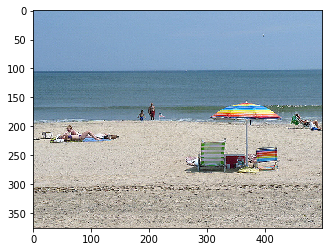

torch.Size([1, 21, 376, 500])
[ 0  9 15]


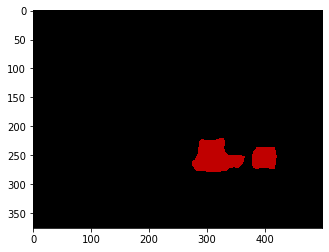

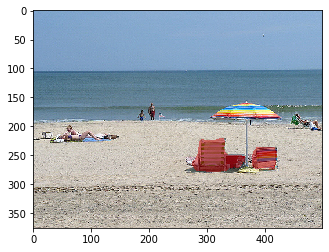

In [0]:
# -*- coding: utf-8 -*-
"""
Based on code from
    https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb
"""

from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import numpy as np
import torchvision.transforms as T
import cv2


def decode_segmap(image, nc):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  # for l in range(0, nc):
  #     idx = image == l
  #     r[idx] = label_colors[l, 0]
  #     g[idx] = label_colors[l, 1]
  #     b[idx] = label_colors[l, 2]
  
  idx = image == nc
  r[idx] = label_colors[nc, 0]
  g[idx] = label_colors[nc, 1]
  b[idx] = label_colors[nc, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb


def apply_mask(im, im_pred):
    """
    Overlays the predicted class labels onto an image using the alpha channel.
    This function assumes that the background label is the black color.
    This function is provided as an inspiration for the masking function you should write.
    """
    r_channel, g_channel, b_channel = cv2.split(im_pred)
    alpha_channel = 127 * np.ones(b_channel.shape, dtype=b_channel.dtype)
    # Make background pixels fully transparent
    alpha_channel -= 127 * np.all(im_pred == np.array([0, 0, 0]), axis=2).astype(b_channel.dtype)
    g_channel=np.zeros(g_channel.shape, dtype=g_channel.dtype)
    b_channel=np.zeros(b_channel.shape, dtype=b_channel.dtype)
    im_pred = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))
    mask = Image.fromarray(im_pred, mode='RGBA')
    masked_img = Image.fromarray(im)
    masked_img.paste(mask, box=None, mask=mask)
    return np.array(masked_img)

# define the model
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
# fcn = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

# load an image
img = Image.open('/content/drive/My Drive/Colab Notebooks/ComputerVision/GHILORIK@TCD.IE.png')
plt.imshow(img); plt.show()

# transform the image
trf = T.Compose([T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

# pass the input through the net
out = fcn(inp)['out']
print (out.shape)

# calculate labels
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (np.unique(om))

# show segmentation output
rgb = decode_segmap(om, 9)
plt.imshow(rgb); plt.show()
predicted = apply_mask(np.array(img), rgb)
plt.imshow(predicted)
plt.show()


#References
https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/

https://en.wikipedia.org/wiki/Convolution

https://arxiv.org/abs/1608.03981

https://pytorch.org/

https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1

https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889
